In [1]:

#source venv311-moment/bin/activate

#pip install -U pip setuptools wheel

#pip install "numpy>=1.26,<2.0"
#pip install "git+https://github.com/moment-timeseries-foundation-model/moment.git"

# MOMENT library:
# !pip install momentfm
#
# Optional: if you use TensorFlow/JAX elsewhere on this machine:
# !pip install tensorflow tensorflow-macos tensorflow-metal
# !pip install jax-metal jax

In [2]:
import sys
from pathlib import Path

# Point to the project root (parent of "models" and "utils")
project_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Project root:", project_root)

Project root: /Users/jan/Documents/working papers/project 1


In [3]:
import os
import math
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Prefer MPS on Apple Silicon if available, otherwise CPU
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")
else:
    DEVICE = torch.device("cpu")

print(f"Using device: {DEVICE}")

Using device: mps


In [4]:
from momentfm import MOMENTPipeline  

@dataclass
class MomentConfig:
    repo_id: str = "AutonLab/MOMENT-1-large"   # or AutonLab/MOMENT-1-base / -small
    horizon: int = 1                           # for trading eval we often score the 1st step
    # You can try longer horizons later (e.g., 12, 24, 96)

def load_moment(cfg: MomentConfig):
    model = MOMENTPipeline.from_pretrained(
        cfg.repo_id,
        model_kwargs={
            "task_name": "forecasting",
            "forecast_horizon": cfg.horizon,
        },
    )
    model.init()  # builds heads / weights, allocates buffers, etc.
    # If the pipeline exposes an internal torch model, it will pick DEVICE when tensors are moved.
    return model

MOMENT_CFG = MomentConfig(horizon=1)
moment = load_moment(MOMENT_CFG)

/Users/jan/Documents/working papers/project 1/venv311-moment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jan/Documents/working papers/project 1/venv311-moment/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/Users/jan/Documents/working papers/project 1/venv311-moment/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [6]:
def load_price_df(obj_or_path, tz_aware=False):

    if isinstance(obj_or_path, pd.DataFrame):
        df = obj_or_path.copy()
    else:
        p = Path(obj_or_path)
        if not p.exists():
            raise FileNotFoundError(f"File not found: {p}")
        df = pd.read_csv(p)

    # Normalize time column name and type
    time_col = None
    for c in df.columns:
        lc = c.lower()
        if lc in ("timestamp", "datetime", "time", "date"):
            time_col = c
            break
    if time_col is None and not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("No datetime column found and index is not DatetimeIndex.")

    if time_col is not None:
        df[time_col] = pd.to_datetime(df[time_col], utc=tz_aware)
        df = df.set_index(time_col)

    df = df.sort_index()
    if "close" not in df.columns:
        # try common variants
        for c in df.columns:
            if c.lower() in ("close", "close_price", "price", "adj_close"):
                df = df.rename(columns={c: "close"})
                break
    if "close" not in df.columns:
        raise ValueError("Expected a 'close' column.")

    df = df[["close"]].astype(float).dropna()
    return df

# Prefer in-memory 'df' if it exists; otherwise point to your CSV
price_df = globals().get("df", None)
if price_df is None:
    # Example: change to your BTC minute CSV path
    price_df = load_price_df('/Users/jan/Documents/working papers/project 1/data/btc_15m_test.csv', tz_aware=False)

print(price_df.head(3))
print(price_df.tail(3))

                        close
timestamp                    
2018-01-01 00:00:00  13999.14
2018-01-01 00:15:00  13886.89
2018-01-01 00:30:00  13920.00
                       close
timestamp                   
2018-04-15 03:15:00  8022.00
2018-04-15 03:30:00  7992.12
2018-04-15 03:45:00  8000.41


In [8]:
CONTEXT_LEN = 512
H = 1   

TOTAL_ROWS = len(price_df)  
TEST_POINTS = TOTAL_ROWS - CONTEXT_LEN - H + 1

assert CONTEXT_LEN >= 32, "Context too short for foundation models."

# Slice tail for evaluation
full = price_df.copy()
test = full.iloc[-(TEST_POINTS + CONTEXT_LEN + H - 1):].copy()

# Z-score normalization for model input; keep stats for de-normalization
mu = test["close"].mean()
sigma = test["close"].std(ddof=0)
test["x"] = (test["close"] - mu) / (sigma if sigma > 0 else 1.0)

# Guardrail: assert no look-ahead by construction (model sees [t−C:t) and predicts [t:t+H))
def assert_no_lookahead(context_end_idx, predict_start_idx):
    assert predict_start_idx == context_end_idx, (
        f"Look-ahead detected: predict_start({predict_start_idx}) "
        f"!= context_end({context_end_idx})"
    )

print(f"Eval window length: {len(test)} | mu={mu:.4f} sigma={sigma:.4f}")

Eval window length: 10000 | mu=10025.2803 sigma=2450.2659


In [9]:
# 1) Load model (task = forecasting). Keep horizon = H (defined earlier).
MOMENT_REPO = "AutonLab/MOMENT-1-small"   # or -base / -small if you need lighter weights
moment = MOMENTPipeline.from_pretrained(
    MOMENT_REPO,
    model_kwargs={
        "task_name": "forecasting",
        "forecast_horizon": int(H),   # usually 1 for your trading eval
        # "n_channels": 1,            # not strictly required for forecasting, default=1
    },
)
moment.init()
moment.eval()

/Users/jan/Documents/working papers/project 1/venv311-moment/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=512, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (

In [10]:
if hasattr(moment, "to"):
    moment.to(DEVICE)
elif hasattr(moment, "model") and hasattr(moment.model, "to"):
    moment.model.to(DEVICE)

In [11]:
def moment_roll_forecast_simple(model, x_series: pd.Series, context_len: int, horizon: int = 1,
                                batch_size: int = 128) -> pd.DataFrame:
    """
    Rolling H-step forecast over x_series (already normalized). Returns y_true/y_pred (denorm).
    """
    x = x_series.to_numpy(dtype=np.float32)
    T = len(x)
    starts = list(range(context_len, T - horizon + 1))

    preds = []
    y_true = []

    for i in range(0, len(starts), batch_size):
        batch_idx = starts[i:i+batch_size]

        # [B, 1, T] windows
        batch_ctx = np.stack([x[s - context_len: s] for s in batch_idx], axis=0).astype(np.float32)  # [B, T]
        batch_ctx = batch_ctx[:, None, :]  # -> [B, 1, T]

        # Forecast — x_enc: [B,C,T], input_mask: [B,T]
        with torch.no_grad():
            x_t = torch.from_numpy(batch_ctx).to(dtype=torch.float32, device=DEVICE)  # [B,1,T]
            B, _, Tlen = x_t.shape
            input_mask = torch.ones(B, Tlen, dtype=torch.bool, device=DEVICE)         # [B,T]
            out = model.forecast(x_enc=x_t, input_mask=input_mask, horizon=int(horizon))

        # -------- robust extraction & shaping --------
        # 1) pull forecast array/tensor out of whatever container
        if isinstance(out, dict):
            y_hat = None
            for k in ("forecast", "prediction", "y_hat", "pred"):
                if k in out:
                    y_hat = out[k]
                    break
            if y_hat is None and len(out) == 1:
                y_hat = next(iter(out.values()))
        else:
            # dataclass-like with attributes?
            y_hat = None
            for k in ("forecast", "prediction", "y_hat", "pred"):
                if hasattr(out, k):
                    y_hat = getattr(out, k)
                    break
            if y_hat is None:
                y_hat = out

        # 2) to numpy
        if hasattr(y_hat, "detach"):
            y_hat = y_hat.detach().cpu().numpy()
        else:
            y_hat = np.asarray(y_hat)

        # 3) normalize shapes to [B, H]
        # Allowed raw cases we've seen:
        #   [B, 1, H], [B, H], [H] (when B==1), [B] (when H==1), scalar (!) — handle all.
        if y_hat.ndim == 3 and y_hat.shape[1] == 1:
            y_hat = y_hat[:, 0, :]             # [B,1,H] -> [B,H]
        elif y_hat.ndim == 3 and y_hat.shape[0] == 1 and y_hat.shape[1] == horizon:
            # rare: [1,H,?] -> try squeeze first dim
            y_hat = y_hat[0]
        if y_hat.ndim == 2:
            pass                                # [B,H] good
        elif y_hat.ndim == 1:
            if y_hat.size == horizon and len(batch_idx) == 1:
                y_hat = y_hat[None, :]          # [H] -> [1,H]
            elif y_hat.size == len(batch_idx) and horizon == 1:
                y_hat = y_hat[:, None]          # [B] (H=1) -> [B,1]
            else:
                # try to infer [B,H]
                if (y_hat.size % horizon) == 0:
                    y_hat = y_hat.reshape(-1, horizon)
                else:
                    raise ValueError(f"Unexpected 1D output shape {y_hat.shape} for B={len(batch_idx)}, H={horizon}")
        elif y_hat.ndim == 0:
            if len(batch_idx) == 1 and horizon == 1:
                y_hat = np.array([[float(y_hat)]])  # scalar -> [1,1]
            else:
                raise ValueError(f"Scalar forecast for B={len(batch_idx)}, H={horizon} is unsupported")
        else:
            # higher dims: best-effort squeeze
            y_hat = np.squeeze(y_hat)
            if y_hat.ndim == 1:
                if y_hat.size == horizon and len(batch_idx) == 1:
                    y_hat = y_hat[None, :]
                elif y_hat.size == len(batch_idx) and horizon == 1:
                    y_hat = y_hat[:, None]
                else:
                    raise ValueError(f"Unexpected squeezed shape {y_hat.shape}")

        # final sanity
        if y_hat.ndim != 2:
            raise ValueError(f"Could not coerce forecast to [B,H]; got {y_hat.shape}")
        if y_hat.shape[0] != len(batch_idx):
            # last attempt: if total size matches B*H, reshape
            if y_hat.size == len(batch_idx) * horizon:
                y_hat = y_hat.reshape(len(batch_idx), horizon)
            else:
                raise ValueError(f"Batch mismatch: forecast {y_hat.shape} vs batch {len(batch_idx)}")
        if y_hat.shape[1] < horizon:
            raise ValueError(f"Returned horizon {y_hat.shape[1]} < requested {horizon}")

        preds.append(y_hat[:, :horizon])

        # collect true values (normalized)
        for s in batch_idx:
            assert_no_lookahead(s, s)
            true_slice = x[s: s + horizon]
            if len(true_slice) == horizon:
                y_true.append(true_slice)

    y_true = np.vstack(y_true)      # [N, H]
    y_pred = np.vstack(preds)       # [N, H]

    # De-normalize back to price space using mu/sigma from your test slice
    scale = (sigma if sigma > 0 else 1.0)
    y_true_denorm = (y_true * scale) + mu
    y_pred_denorm = (y_pred * scale) + mu

    # Index aligned to the first forecasted step per window
    idx = x_series.index[context_len - 1 : context_len - 1 + len(y_true_denorm)]
    out_df = pd.DataFrame(
        {"y_true": y_true_denorm[:, 0], "y_pred": y_pred_denorm[:, 0]},
        index=idx,
    )

    if horizon > 1:
        for h in range(horizon):
            out_df[f"y_pred_h{h+1}"] = y_pred_denorm[:, h]

    return out_df

# run
pred_df = moment_roll_forecast_simple(moment, test["x"], context_len=CONTEXT_LEN, horizon=H, batch_size=128)
pred_df.head()

,y_true,y_pred
timestamp,,
2018-01-06 07:45:00,16669.480469,14906.257812
2018-01-06 08:00:00,16710.359375,14910.232422
2018-01-06 08:15:00,16634.189453,14924.667969
2018-01-06 08:30:00,16547.810547,14936.874023
2018-01-06 08:45:00,16462.050781,14955.339844


In [12]:
# save predictions
OUT_PRED_CSV = project_root / "models" / "moment_zeroshot_btc_preds.csv"

pred_df_reset = pred_df.reset_index().rename(columns={"index": "timestamp"})
pred_df_reset.to_csv(OUT_PRED_CSV, index=False)

print(f"Saved predictions to: {OUT_PRED_CSV}   (rows={len(pred_df_reset)})")

Saved predictions to: /Users/jan/Documents/working papers/project 1/models/moment_zeroshot_btc_preds.csv   (rows=9488)


In [13]:
import pandas as pd
from utils.metrics import evaluate_forecast

df = pd.read_csv(project_root / "models" / "moment_zeroshot_btc_preds.csv", parse_dates=["timestamp"])

res = evaluate_forecast(
    df["y_true"], df["y_pred"], df["timestamp"],
    starting_capital=100_000, threshold=0.005, fee_rate=0.001
)

eq_end_no = float(res["equity_no_tc"].iloc[-1])
eq_end_tc = float(res["equity_tc"].iloc[-1])
cum_fee   = float(res["cum_fee"].iloc[-1])

print(f"Final equity (no fees):   {eq_end_no:,.2f}")
print(f"Final equity (with fees): {eq_end_tc:,.2f}")
print(f"Total fees paid:          {cum_fee:,.2f}")

# metrics
for k in ["arc", "asd", "mdd", "ir_star", "ir_starstar"]:
    v = res[k]
    print(f"{k}: {v:.6f}" if isinstance(v, float) else f"{k}: {v}")

Final equity (no fees):   79,204.64
Final equity (with fees): 52,605.16
Total fees paid:          33,150.23
arc: -0.906906
asd: 1.351259
mdd: 0.561456
ir_star: -0.671157
ir_starstar: -1.084104


In [14]:

df = df.copy()
df["equity"]    = res["equity_no_tc"].to_numpy(float)
df["equity_tc"] = res["equity_tc"].to_numpy(float)
df["fee"]       = res["fee"].to_numpy(float)
df["cum_fee"]   = res["cum_fee"].to_numpy(float)


print(df[["timestamp","y_true","y_pred","equity","equity_tc","cum_fee"]].head(3))
print(df[["timestamp","y_true","y_pred","equity","equity_tc","cum_fee"]].tail(3))

            timestamp    y_true     y_pred         equity      equity_tc  \
0 2018-01-06 07:45:00  16669.48  14906.258  100000.000000  100000.000000   
1 2018-01-06 08:00:00  16710.36  14910.232   99754.761396   99655.006635   
2 2018-01-06 08:15:00  16634.19  14924.668  100209.468547  100109.259078   

   cum_fee  
0      0.0  
1    100.0  
2    100.0  
               timestamp   y_true     y_pred        equity     equity_tc  \
9485 2018-04-15 03:00:00  8022.00  7476.8290  78992.657455  52464.368086   
9486 2018-04-15 03:15:00  7992.12  7478.0435  79286.885902  52659.785104   
9487 2018-04-15 03:30:00  8000.41  7478.2230  79204.643858  52605.162598   

           cum_fee  
9485  33150.226826  
9486  33150.226826  
9487  33150.226826  


(<Figure size 1200x800 with 2 Axes>,
 (<Axes: title={'center': 'MOMENT zero-shot BTC 1h'}, ylabel='Price'>,
  <Axes: title={'center': 'Equity (with fees) vs B&H'}, xlabel='Time', ylabel='Equity'>))

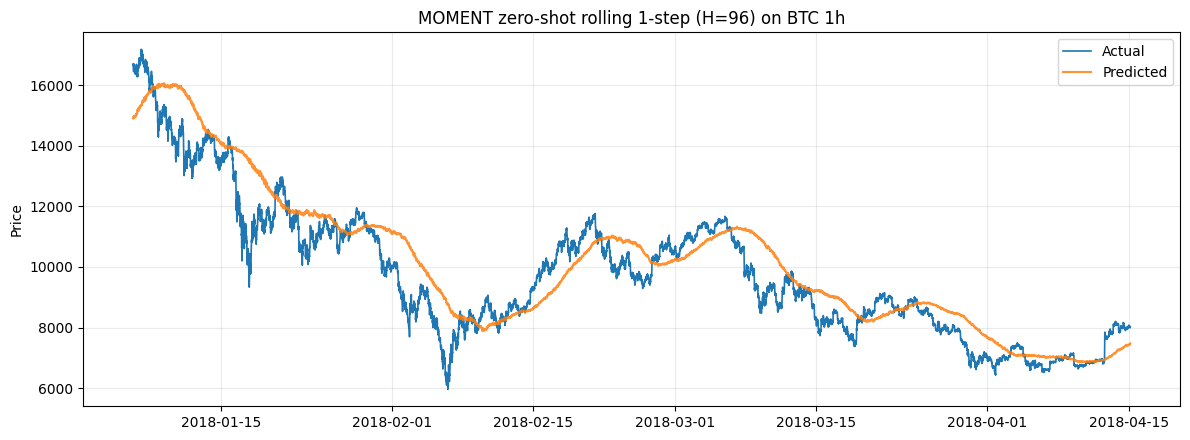

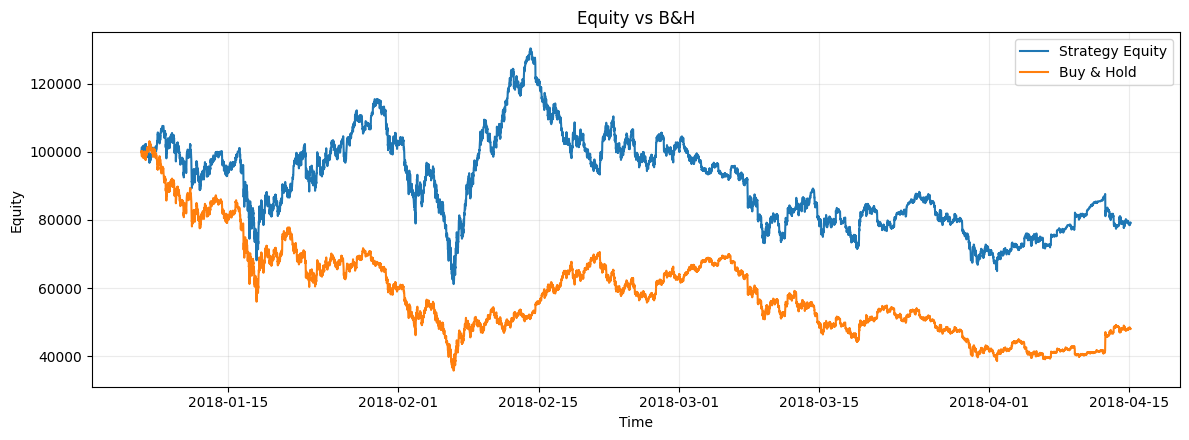

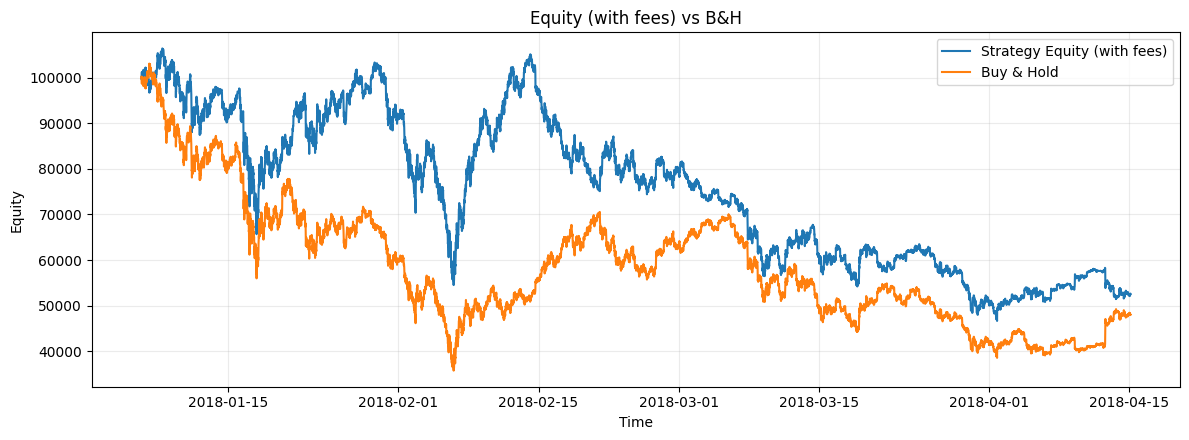

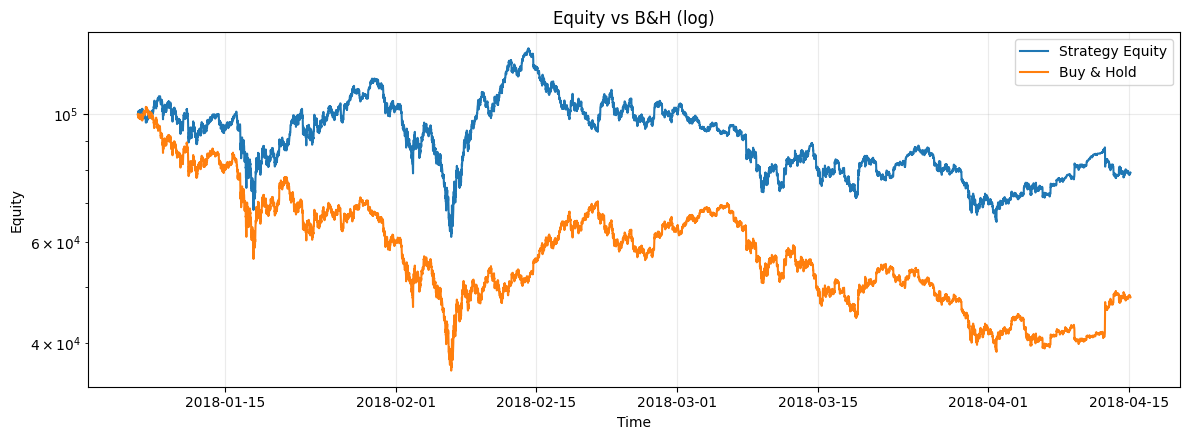

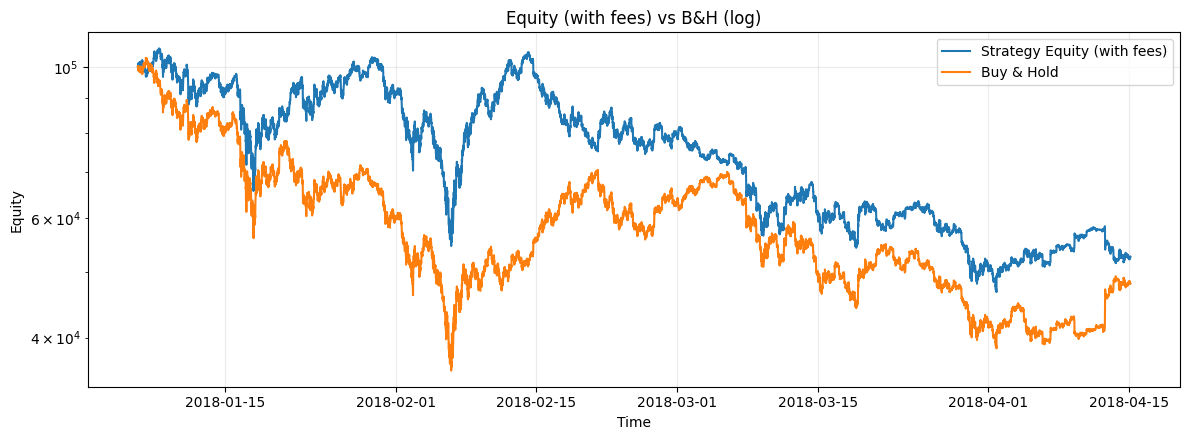

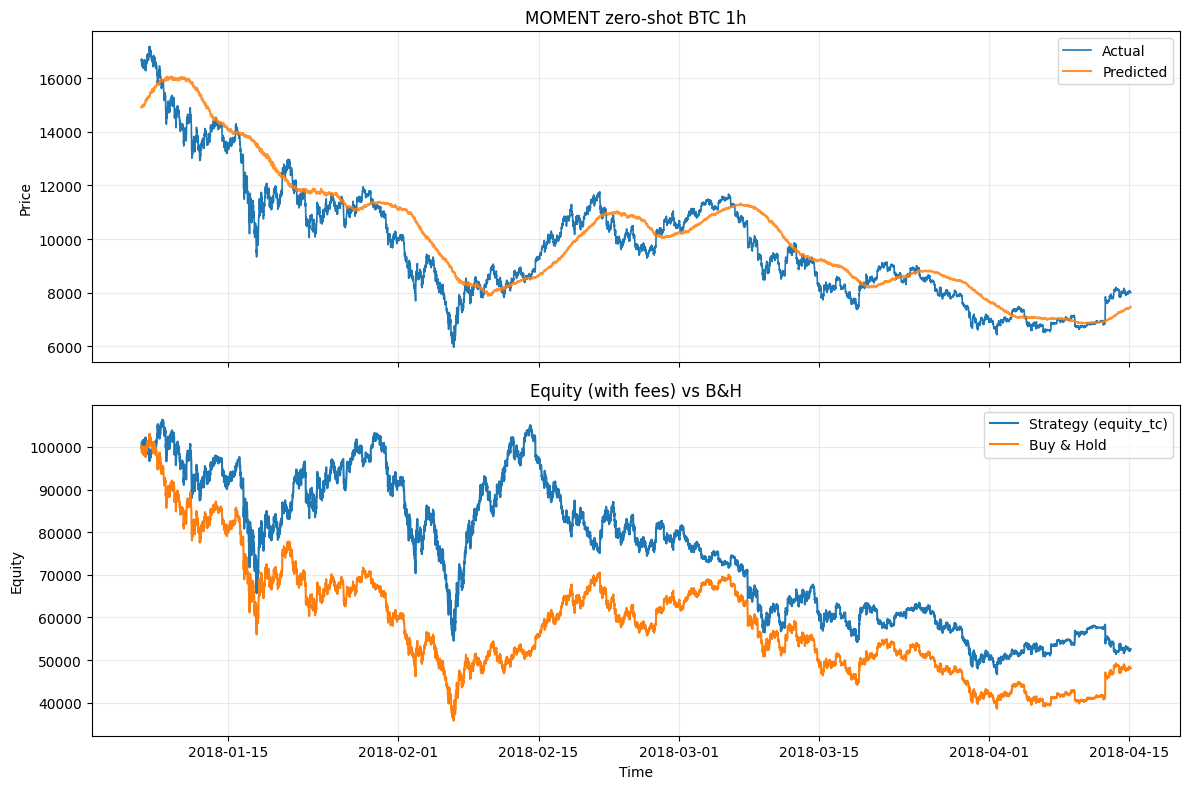

In [15]:
from utils.plotting import (
    plot_price_actual_vs_pred,
    plot_equity_no_tc_vs_bh,
    plot_equity_tc_vs_bh,
    plot_equity_no_tc_vs_bh_log,
    plot_equity_tc_vs_bh_log,
    plot_price_and_equity_panel,
)

plot_price_actual_vs_pred(df, title="MOMENT zero-shot rolling 1-step (H=96) on BTC 1h")
plot_equity_no_tc_vs_bh(df, title="Equity vs B&H")
plot_equity_tc_vs_bh(df, title="Equity (with fees) vs B&H")
plot_equity_no_tc_vs_bh_log(df, title="Equity vs B&H (log)")
plot_equity_tc_vs_bh_log(df, title="Equity (with fees) vs B&H (log)")
plot_price_and_equity_panel(
    df,
    equity_col="equity_tc",  # or "equity"
    title_price="MOMENT zero-shot BTC 1h",
    title_equity="Equity (with fees) vs B&H",
    logy_equity=False,
)